In [16]:
from google.colab import drive
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np


drive.mount('/content/drive')
file = open('/content/drive/My Drive/max plank/mpi_saale_2013_2020.csv')
df = pd.read_csv(file)

df.set_index('Date Time')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,p (mbar),T (degC),rh (%),sh (g/kg),Tpot (K),Tdew (degC),VPmax (mbar),VPact (mbar),VPdef (mbar),H2OC (mmol/mol),rho (g/m**3),wv (m/s),wd (deg),TRAD (degC),Rn (W/m**2)
Date Time,,,,,,,,,,,,,,,
01.07.2013 00:10:04,1003.63,12.32,94.2,8.42,285.18,11.42,14.34,13.51,0.83,13.46,1218.46,0.71,167.70,0.00,0.00
01.07.2013 00:20:04,1003.58,12.39,94.5,8.48,285.26,11.53,14.41,13.62,0.79,13.57,1218.05,0.46,142.50,0.00,0.00
01.07.2013 00:30:04,1003.52,12.38,95.5,8.57,285.25,11.68,14.40,13.75,0.65,13.70,1217.96,0.39,119.10,0.00,0.00
01.07.2013 00:40:04,1003.50,12.73,91.6,8.41,285.60,11.40,14.74,13.50,1.24,13.45,1216.56,0.32,96.10,0.00,0.00
01.07.2013 00:50:04,1003.47,13.14,88.3,8.33,286.02,11.25,15.14,13.37,1.77,13.32,1214.84,0.42,165.40,0.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31.12.2020 23:20:00,988.15,2.16,85.8,3.86,276.25,0.04,7.14,6.13,1.01,6.20,1247.42,1.06,42.76,0.86,-6.53
31.12.2020 23:30:00,988.13,2.15,88.6,3.99,276.24,0.47,7.13,6.32,0.81,6.40,1247.34,0.95,99.60,0.78,-7.59
31.12.2020 23:40:00,988.07,2.03,88.8,3.96,276.13,0.39,7.07,6.28,0.79,6.36,1247.82,0.74,0.00,0.65,-9.78


In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 211551 entries, 0 to 211550
Data columns (total 16 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   Date Time        211551 non-null  object 
 1   p (mbar)         211551 non-null  float64
 2   T (degC)         211551 non-null  float64
 3   rh (%)           211551 non-null  float64
 4   sh (g/kg)        211551 non-null  float64
 5   Tpot (K)         211551 non-null  float64
 6   Tdew (degC)      211551 non-null  float64
 7   VPmax (mbar)     211551 non-null  float64
 8   VPact (mbar)     211551 non-null  float64
 9   VPdef (mbar)     211551 non-null  float64
 10  H2OC (mmol/mol)  211551 non-null  float64
 11  rho (g/m**3)     211551 non-null  float64
 12  wv (m/s)         211551 non-null  float64
 13  wd (deg)         211551 non-null  float64
 14  TRAD (degC)      211551 non-null  float64
 15  Rn (W/m**2)      211551 non-null  float64
dtypes: float64(15), object(1)
memory usage

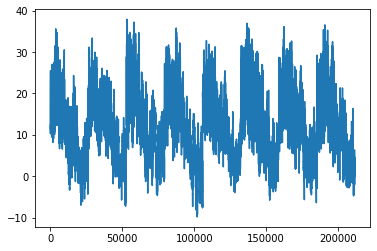

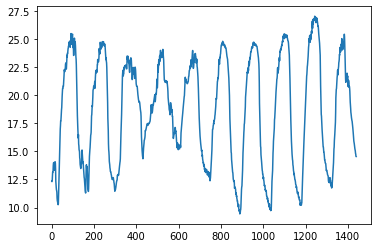

In [7]:
'''데이터 시각화'''

# 온도의 시계열성
temp = df['T (degC)'] # 온도(섭씨) 열
plt.plot(range(len(temp)), temp)
plt.show()

# 10일동안의 시계열성
plt.plot(range(1440), temp[:1440]) # 1440 = (6*24)*10
plt.show()

In [26]:
def ts_train_test(df, time_steps, for_periods):
  ts_train = df[:'31.12.2019 23:50:04'].iloc[:,2:3].values
  ts_test = df['01.01.2020 00:00:04':].iloc[:,2:3].values
  ts_train_len = len(ts_train)
  ts_test_len = len(ts_test)

  X_train = []
  Y_train = []
  Y_train_stacked = []
  for i in range(time_steps, ts_train_len - 1):
    X_train.append(ts_train[i-time_steps:i,0])
    Y_train.append(ts_train[i:i+for_periods,0])
  X_train, Y_train = np.array(X_train), np.array(Y_train)

  X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1],1))

  inputs = pd.concat((df['T (degC)'][:'31.12.2019 23:50:04'], df['T (degC)']['01.01.2020 00:00:04':]), axis = 0).values
  inputs = inputs[len(inputs) - len(ts_test) - time_steps:]
  inputs = inputs.reshape(-1,1)

  X_test = []
  for i in range(time_steps, ts_test_len + time_steps - for_periods):
    X_test.append(inputs[i - time_steps:i,0])
  X_test = np.array(X_test)
  X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1],1))

  return X_train, Y_train, X_test

In [28]:
X_train, Y_train, X_test = ts_train_test(df,5,2)

X_train_see = pd.DataFrame(np.reshape(X_train, (X_train.shape[0], X_train.shape[1])))
Y_train_see = pd.DataFrame(Y_train)
pd.concat([X_train_see, Y_train_see], axis = 1)

X_test_see = pd.DataFrame(np.reshape(X_test, (X_test.shape[0], X_test.shape[1])))
pd.DataFrame(X_test_see)

print('There are' + str(X_train.shape[0]) + 'samples in the training data')
print('There are' + str(X_test.shape[0]) + 'samples in the test data')

TypeError: ignored

In [ ]:
import numpy as np

float_data = np.zeros((len(lines), len(header) - 1))
for i, line in enumerate(lines):
  for j in line.split(',')[1:]:
    if type(j) is str:
      print(i, j)
      break
    
  
  values = [float(x) for x in line.split(',')[1:]] # Date time 칼럼을 제외한 데이터
  float_data[i, :] = values

In [ ]:
'''정규화 과정'''
# 표준정규 분포로 정규화

mean = float_data[:len(float_data)].mean(axis = 0) # 각 열 마다 평균을 구함
float_data -= mean
std = float_data[:len(float_data)].std(axis = 0)
float_data /= std

In [ ]:
'''
lookback = 1440 10일 전 데이터로 돌아감.
steps = 6 : 한 시간 마다 데이터 포인트 하나를 샘플링.
delay = 144 : 24시간이 지난 데이터가 타깃.
'''
def generator(data, lookback, delay, min_index, max_index, shuffle = False, batch_size = 128, step = 6):
  if max_index is None:  # 없으면 타깃 빼고 나머지 전부
    max_index = len(data) - delay - 1
  i = min_index + lookback 
  while 1:
    if shuffle:
      '''셔플해서 1440~20만까지 중 순서는 섞어줌'''
      '''10일 전 -> 담날 예측은 유지'''
      rows = np.random.randint(
          min_index + lookback, max_index, size = batch_size)
    else:
      if i + batch_size >= max_index:
        i = min_index + lookback
      rows = np.arrange(i,min(i + batch_size, max_index))
      i += len(rows)

    samples = np.zeros((len(rows),
                        lookback // step,
                        data.shape[-1]))
    targets = np.zeros((len(rows),))
    for j, row in enumerate(rows):
      indices = range(rows[j] - lookback, rows[j], step)
      samples[j] = data[indices]
      targets[j] = data[rows[j] + delay][1]
    yield samples, targets

In [ ]:
lookback = 1440
step = 6
delay = 144
batch_size - 128

train_gen = generator(float_data,
                      lookback = lookback,
                      delay = delay,
                      max_index = 0,
                      max_index = 200000,
                      shuffle = True,
                      step = step
                      batch_size = batch_size)

val_gen = generator(float_data,
                    lookback=lookback,
                    delay=delay
                    min_index = 200001,
                    max_index = 300001,
                    step = step,
                    batch_size = batch_size)

test_gen = generator(float_data,
                     lookback = lookback,
                     delay = delay,
                     min_index = 300001,
                     max_index = None,
                     step = step,
                     batch_size = batch_size)

val_steps = (300000 - 200001 - lookback) // batch_size